<a href="https://colab.research.google.com/github/09334677600f/Code-for-Chapter-4/blob/main/ANN_Survival2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 413.9/413.9 kB 14.3 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim

from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_absolute_error, mean_squared_error

import optuna
import matplotlib.pyplot as plt
import shap


In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, KFold
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import optuna
import shap

In [ ]:
df = pd.read_excel("/content/final_file1 (2) (1).xlsx")

In [ ]:
pip install scikit-survival

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.0/4.0 MB 34.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 30.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 222.1/222.1 kB 8.2 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.6.1
    Uninstalling scikit-learn-1.6.1:
      Successfully uninstalled scikit-learn-1.6.1


In [ ]:
# ستون‌هایی که حذف می‌شوند
columns_to_drop = [
    "ID", "Accident_ID", "تعداد تصادف", "تاریخ",
    "زمان تماس", "ساعت رسیدن به محل حادثه"
]

df = df.drop(columns=[c for c in columns_to_drop if c in df.columns])

# حذف ردیف‌های NaN
df = df.dropna()
print(f"تعداد رکورد بعد از حذف NaN: {df.shape[0]}")

# انتخاب ویژگی‌ها و هدف
X_cols = [
    "سن بیمار", "جنسیت", "زمان شب و روز",
    "نوع روز", "فصل", "ساعت اوج ترافیک"
]

X = df[X_cols].copy()
y = df[["مدت زمان", "وضعیت"]].copy()   # 1 = event, 0 = censored

# تعریف ستون‌های دسته‌ای و عددی
categorical_cols = ["جنسیت", "زمان شب و روز", "نوع روز", "فصل", "ساعت اوج ترافیک"]
numeric_cols = ["سن بیمار"]

# پیش‌پردازش
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_cols),
        ('cat', OneHotEncoder(drop='first', sparse_output=False), categorical_cols)
    ],
    remainder='drop'
)

X_processed = preprocessor.fit_transform(X)
print(f"شکل داده پس از پیش‌پردازش: {X_processed.shape}")

# نام ستون‌های نهایی
feature_names = (
    numeric_cols +
    preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_cols).tolist()
)
print("ویژگی‌ها:", feature_names)

تعداد رکورد بعد از حذف NaN: 22103
شکل داده پس از پیش‌پردازش: (22103, 8)
ویژگی‌ها: ['سن بیمار', 'جنسیت_مونث', 'زمان شب و روز_شب', 'نوع روز_اول هفته', 'فصل_تابستان', 'فصل_زمستان', 'فصل_پاییز', 'ساعت اوج ترافیک_خارج از اوج']


In [ ]:
# تبدیل به فرمت مورد نیاز sksurv
event_indicator = y["وضعیت"].astype(bool)
time = y["مدت زمان"].astype(float)

y_structured = np.array(
    list(zip(event_indicator, time)),
    dtype=[('event', bool), ('time', float)]
)

# تقسیم train/test
X_train, X_test, y_train, y_test = train_test_split(
    X_processed, y_structured,
    test_size=0.2,
    random_state=42,
    stratify=event_indicator
)

print(f"Train: {X_train.shape[0]} رکورد | Test: {X_test.shape[0]} رکورد")
print(f"نرخ رویداد در train: {y_train['event'].mean():.3f}")

Train: 17682 رکورد | Test: 4421 رکورد
نرخ رویداد در train: 0.344


ANN-Survival

In [ ]:

# پیش‌پردازش داده

columns_to_drop = [
    "ID", "Accident_ID", "تعداد تصادف",
    "تاریخ", "زمان تماس", "ساعت رسیدن به محل حادثه"
]
df = df.drop(columns=[c for c in columns_to_drop if c in df.columns])

df = df.dropna()
print(f"تعداد رکورد بعد از حذف NaN: {df.shape[0]}")

X_cols = [
    "سن بیمار", "جنسیت", "زمان شب و روز",
    "نوع روز", "فصل", "ساعت اوج ترافیک"
]
X = df[X_cols].copy()
y = df[["مدت زمان", "وضعیت"]].copy()  # وضعیت: 1=event, 0=censored

categorical_cols = ["جنسیت", "زمان شب و روز", "نوع روز", "فصل", "ساعت اوج ترافیک"]
numeric_cols = ["سن بیمار"]

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_cols),
        ('cat', OneHotEncoder(drop='first', sparse_output=False), categorical_cols)
    ]
)

X_processed = preprocessor.fit_transform(X)

feature_names = (
    numeric_cols +
    preprocessor.named_transformers_['cat']
    .get_feature_names_out(categorical_cols).tolist()
)

event = y["وضعیت"].astype(int).values
time = y["مدت زمان"].astype(float).values

X_train, X_test, t_train, t_test, e_train, e_test = train_test_split(
    X_processed, time, event,
    test_size=0.2, random_state=42, stratify=event
)

print(f"Train: {X_train.shape}, Test: {X_test.shape}")


تعداد رکورد بعد از حذف NaN: 22103
Train: (17682, 8), Test: (4421, 8)


In [ ]:
N_BINS = 8
BIN_EDGES = np.arange(1, 9)

def time_to_bin(t):
    return min(int(np.floor(t)), 8) - 1

def make_survival_targets(time, event):
    y_bin = np.array([time_to_bin(t) for t in time])
    return y_bin, event


In [ ]:
class SurvivalMLP(nn.Module):
    def __init__(self, input_dim, hidden_layers, dropout):
        super().__init__()
        layers = []
        prev = input_dim

        for h in hidden_layers:
            layers.append(nn.Linear(prev, h))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout))
            prev = h

        self.hidden = nn.Sequential(*layers)
        self.output = nn.Linear(prev, N_BINS)

    def forward(self, x):
        x = self.hidden(x)
        return torch.softmax(self.output(x), dim=1)


In [ ]:
def survival_nll(p, t_bin, event):
    eps = 1e-8
    f = p[torch.arange(len(p)), t_bin]
    S = 1 - torch.cumsum(p, dim=1)
    S_t = S[torch.arange(len(p)), t_bin]

    loss = -torch.mean(
        event * torch.log(f + eps) +
        (1 - event) * torch.log(S_t + eps)
    )
    return loss


In [ ]:
def objective(trial):
    hidden_layers = [
        trial.suggest_int("h1", 16, 128),
        trial.suggest_int("h2", 16, 128)
    ]
    lr = trial.suggest_float("lr", 1e-4, 1e-2, log=True)
    batch_size = trial.suggest_categorical("batch", [64, 128, 256])
    dropout = trial.suggest_float("dropout", 0.0, 0.4)

    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    losses = []

    for tr, val in kf.split(X_train):
        model = SurvivalMLP(X_train.shape[1], hidden_layers, dropout)
        optimizer = optim.Adam(model.parameters(), lr=lr)

        Xtr = torch.tensor(X_train[tr], dtype=torch.float32)
        Xva = torch.tensor(X_train[val], dtype=torch.float32)

        tb_tr, ev_tr = make_survival_targets(t_train[tr], e_train[tr])
        tb_va, ev_va = make_survival_targets(t_train[val], e_train[val])

        tb_tr = torch.tensor(tb_tr)
        ev_tr = torch.tensor(ev_tr, dtype=torch.float32)
        tb_va = torch.tensor(tb_va)
        ev_va = torch.tensor(ev_va, dtype=torch.float32)

        for _ in range(100):
            optimizer.zero_grad()
            p = model(Xtr)
            loss = survival_nll(p, tb_tr, ev_tr)
            loss.backward()
            optimizer.step()

        with torch.no_grad():
            val_loss = survival_nll(model(Xva), tb_va, ev_va)
            losses.append(val_loss.item())

    return np.mean(losses)


In [ ]:
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=30)

print("Best params:", study.best_params)


[I 2026-02-07 04:44:14,038] A new study created in memory with name: no-name-15deeebb-0198-4fc2-9eaf-93a2b1853425
[W 2026-02-07 04:45:16,106] Trial 0 failed with parameters: {'h1': 119, 'h2': 79, 'lr': 0.00026188616262374446, 'batch': 128, 'dropout': 0.35994030305581093} because of the following error: The value nan is not acceptable.
[W 2026-02-07 04:45:16,108] Trial 0 failed with value np.float64(nan).
[W 2026-02-07 04:45:49,772] Trial 1 failed with parameters: {'h1': 73, 'h2': 62, 'lr': 0.0024527110656741916, 'batch': 256, 'dropout': 0.26380312197445377} because of the following error: The value nan is not acceptable.
[W 2026-02-07 04:45:49,773] Trial 1 failed with value np.float64(nan).
[W 2026-02-07 04:46:04,542] Trial 2 failed with parameters: {'h1': 56, 'h2': 20, 'lr': 0.0018989096060118866, 'batch': 128, 'dropout': 0.011025489384317577} because of the following error: The value nan is not acceptable.
[W 2026-02-07 04:46:04,543] Trial 2 failed with value np.float64(nan).
[W 2026

Best params: {'h1': 85, 'h2': 90, 'lr': 0.005833604487432145, 'batch': 256, 'dropout': 0.0297188078248805}


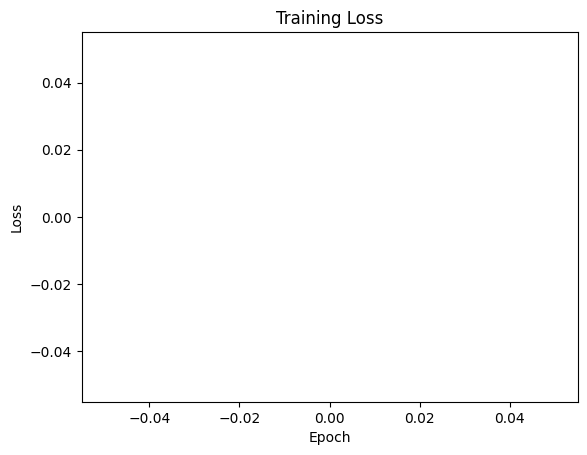

In [ ]:
params = study.best_params
model = SurvivalMLP(
    X_train.shape[1],
    [params["h1"], params["h2"]],
    params["dropout"]
)

optimizer = optim.Adam(model.parameters(), lr=params["lr"])
batch_size = params["batch"]

tb_train, ev_train = make_survival_targets(t_train, e_train)
tb_train = torch.tensor(tb_train)
ev_train = torch.tensor(ev_train, dtype=torch.float32)
Xtr = torch.tensor(X_train, dtype=torch.float32)

train_losses = []

for epoch in range(100):
    optimizer.zero_grad()
    p = model(Xtr)
    loss = survival_nll(p, tb_train, ev_train)
    loss.backward()
    optimizer.step()
    train_losses.append(loss.item())

plt.plot(train_losses)
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()


In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

def expected_time(p):
    bins = torch.arange(1, 9).float()
    return torch.sum(p * bins, dim=1)

model.eval()
with torch.no_grad():
    Xte = torch.tensor(X_test, dtype=torch.float32)
    p = model(Xte)
    t_pred = expected_time(p).numpy()

# محاسبه معیارهای ارزیابی
mae = mean_absolute_error(t_test, t_pred)

mse = mean_squared_error(t_test, t_pred)
rmse = np.sqrt(mse)

mape = np.mean(np.abs((t_test - t_pred) / t_test))

print(f"MAE:  {mae:.3f}")
print(f"RMSE: {rmse:.3f}")
print(f"MAPE: {mape:.3f}")


MAE:  5.214
RMSE: 7.982
MAPE: 0.403


In [ ]:
def c_index(t, p, e):
    concordant = 0
    permissible = 0
    for i in range(len(t)):
        for j in range(len(t)):
            if t[i] < t[j] and e[i] == 1:
                permissible += 1
                concordant += p[i] < p[j]
    return concordant / permissible

cidx = c_index(t_test, t_pred, e_test)
print(f"C-index: {cidx:.3f}")


C-index: 0.613
